In [8]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append("../../")
sys.path.append("../")

In [3]:
import torchvision
import os
import torch
import time
from pathlib import Path
from PIL import Image
import numpy as np
import cv2
import torchvision
import xml.etree.ElementTree as ET
from random import randrange

from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from references.detection import utils
from references.detection import transforms as T
from references.detection.engine import train_one_epoch, evaluate

from matplotlib import pyplot as plt

from utils_cv.common.data import unzip_url, data_path

Helper function to display images with annotations.


In [4]:
def display_annotations(im_path, boxes, labels, categories):
    rect_th = 2
    text_size = 0.8
    text_th = 2
    color = (255, 0, 0)

    # Read image with cv2
    im = cv2.imread(str(im_path))

    # Convert to RGB
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

    if len(boxes) > 0:
        for i in range(len(boxes)):

            # reformat boxes to be consumable by cv2
            box = [(boxes[i][0], boxes[i][1]), (boxes[i][2], boxes[i][3])]

            # Draw Rectangle with the coordinates
            cv2.rectangle(
                im, box[0], box[1], color=color, thickness=rect_th
            )

            # Write the prediction class
            cv2.putText(
                im,
                categories[labels[i]],
                box[0],
                cv2.FONT_HERSHEY_SIMPLEX,
                text_size,
                color=color,
                thickness=text_th,
            )

    # display the output image
    plt.figure(figsize=(8, 12))
    plt.imshow(im)
    plt.xticks([])
    plt.yticks([])
    plt.show()

### Load data

In [5]:
class FridgeObjectsDataset(object):
    def __init__(self, root, transforms):
        self.root = Path(root)
        self.transforms = transforms

        self.ims = list(sorted(os.listdir(root / "images")))
        self.annotations = list(sorted(os.listdir(root / "annotations")))
        self.category_names = ["__background__", "can", "carton", "milk_bottle", "water_bottle"]

    def _get_annotations(self, annotation_path):
        boxes = []
        labels = []
        tree = ET.parse(annotation_path)
        root = tree.getroot()
        objs = root.findall("object")

        for obj in objs:
            label = obj[0]
            assert label.tag == "name"

            bnd_box = obj[4]
            assert bnd_box.tag == "bndbox"
            
            xmin = int(bnd_box[0].text)
            ymin = int(bnd_box[1].text)
            xmax = int(bnd_box[2].text)
            ymax = int(bnd_box[3].text)

            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(self.category_names.index(label.text))

        return (boxes, labels)

    def __getitem__(self, idx):

        # get box/labels from annotations
        annotation_path = self.root / "annotations" / str(self.annotations[idx])
        boxes, labels = self._get_annotations(annotation_path)

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        # convert labels to torch.Tensor
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # get area for evaluation with the COCO metric, to separate the
        # metric scores between small, medium and large boxes.
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # suppose all instances are not crowd
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

        # unique id
        im_id = torch.tensor([idx])

        # setup target dic
        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": im_id,
            "area": area,
            "iscrowd": iscrowd
        }
        
        # get image 
        im_path = self.root / "images" / str(self.ims[idx])
        im = Image.open(im_path).convert("RGB")
        
        # and apply transforms if any
        if self.transforms is not None:
            im, target = self.transforms(im, target)

        return (im, target)

    def __len__(self):
        return len(self.ims)


Make sure the bounding boxes look right:

In [6]:
path = Path(
    unzip_url(
        "https://cvbp.blob.core.windows.net/public/datasets/object_detection/odFridgeObjects.zip", exist_ok=True
    )
)

dataset = FridgeObjectsDataset(path, None)

# choose and get image from dataset
rand_idx = randrange(len(dataset.ims))
im_path = dataset.root / "images" / str(dataset.ims[rand_idx])

# get boxes and labels from dataset
annotation_path = dataset.root / "annotations" / str(dataset.annotations[rand_idx])
boxes, labels = dataset._get_annotations(annotation_path)

# get categories from dataset
categories = dataset.category_names

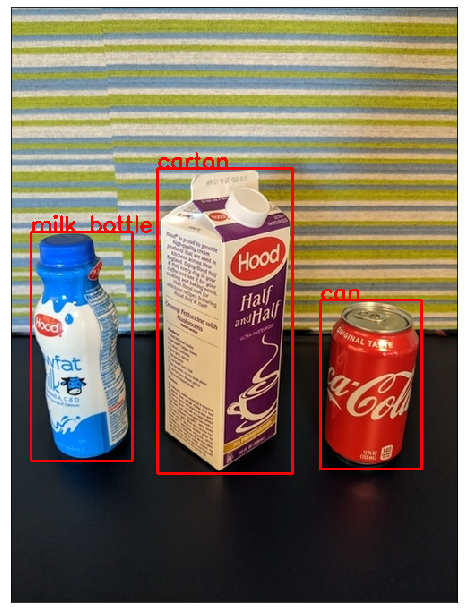

In [9]:
display_annotations(im_path, boxes, labels, categories)

In [10]:
# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

### Finetuning from a pretrained model
Let’s suppose that you want to start from a model pre-trained on COCO and want to finetune it for your particular classes. 

In [11]:
def get_pretrained_model():
    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # replace the classifier with a new one, that has num_classes which is user-defined
    num_classes = 5  # 5 class (can, carton, milk_bottle, water_bottle) + background

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model

### Putting it all together

In [12]:
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

Let’s now write the main function which performs the training and the validation:

In [13]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# our dataset has two classes only - background and person
num_classes = 5

# use our dataset and defined transformations
dataset = FridgeObjectsDataset(path, get_transform(train=True))
dataset_test = FridgeObjectsDataset(path, get_transform(train=False))
categories = dataset.category_names

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4, collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    collate_fn=utils.collate_fn,
)

In [14]:
# get the model using our helper function
model = get_pretrained_model()

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [15]:
# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    
    # update the learning rate
    lr_scheduler.step()
    
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/39]  eta: 0:00:46  lr: 0.000136  loss: 1.7908 (1.7908)  loss_classifier: 1.5267 (1.5267)  loss_box_reg: 0.2474 (0.2474)  loss_objectness: 0.0051 (0.0051)  loss_rpn_box_reg: 0.0116 (0.0116)  time: 1.1932  data: 0.2019  max mem: 2925
Epoch: [0]  [10/39]  eta: 0:00:08  lr: 0.001451  loss: 0.8317 (1.0372)  loss_classifier: 0.6387 (0.8207)  loss_box_reg: 0.2010 (0.2037)  loss_objectness: 0.0032 (0.0040)  loss_rpn_box_reg: 0.0100 (0.0088)  time: 0.2862  data: 0.0228  max mem: 3534
Epoch: [0]  [20/39]  eta: 0:00:04  lr: 0.002765  loss: 0.6785 (0.8611)  loss_classifier: 0.4203 (0.6294)  loss_box_reg: 0.2145 (0.2198)  loss_objectness: 0.0023 (0.0032)  loss_rpn_box_reg: 0.0071 (0.0086)  time: 0.1953  data: 0.0053  max mem: 3535
Epoch: [0]  [30/39]  eta: 0:00:02  lr: 0.004080  loss: 0.5119 (0.7201)  loss_classifier: 0.2493 (0.4903)  loss_box_reg: 0.2172 (0.2179)  loss_objectness: 0.0016 (0.0028)  loss_rpn_box_reg: 0.0085 (0.0091)  time: 0.1949  data: 0.0055  max mem: 3535
Epoch: [

Epoch: [3]  [ 0/39]  eta: 0:00:14  lr: 0.000500  loss: 0.1040 (0.1040)  loss_classifier: 0.0535 (0.0535)  loss_box_reg: 0.0431 (0.0431)  loss_objectness: 0.0010 (0.0010)  loss_rpn_box_reg: 0.0065 (0.0065)  time: 0.3610  data: 0.1508  max mem: 3536
Epoch: [3]  [10/39]  eta: 0:00:06  lr: 0.000500  loss: 0.0430 (0.0486)  loss_classifier: 0.0266 (0.0287)  loss_box_reg: 0.0107 (0.0139)  loss_objectness: 0.0002 (0.0004)  loss_rpn_box_reg: 0.0058 (0.0055)  time: 0.2108  data: 0.0187  max mem: 3536
Epoch: [3]  [20/39]  eta: 0:00:03  lr: 0.000500  loss: 0.0430 (0.0499)  loss_classifier: 0.0266 (0.0288)  loss_box_reg: 0.0112 (0.0146)  loss_objectness: 0.0001 (0.0008)  loss_rpn_box_reg: 0.0058 (0.0057)  time: 0.1960  data: 0.0057  max mem: 3536
Epoch: [3]  [30/39]  eta: 0:00:01  lr: 0.000500  loss: 0.0438 (0.0495)  loss_classifier: 0.0263 (0.0286)  loss_box_reg: 0.0130 (0.0143)  loss_objectness: 0.0002 (0.0007)  loss_rpn_box_reg: 0.0054 (0.0058)  time: 0.1958  data: 0.0057  max mem: 3536
Epoch: [

Epoch: [6]  [ 0/39]  eta: 0:00:17  lr: 0.000050  loss: 0.0311 (0.0311)  loss_classifier: 0.0192 (0.0192)  loss_box_reg: 0.0077 (0.0077)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0040 (0.0040)  time: 0.4453  data: 0.2340  max mem: 3539
Epoch: [6]  [10/39]  eta: 0:00:06  lr: 0.000050  loss: 0.0412 (0.0417)  loss_classifier: 0.0257 (0.0257)  loss_box_reg: 0.0107 (0.0102)  loss_objectness: 0.0001 (0.0013)  loss_rpn_box_reg: 0.0048 (0.0045)  time: 0.2173  data: 0.0251  max mem: 3540
Epoch: [6]  [20/39]  eta: 0:00:03  lr: 0.000050  loss: 0.0416 (0.0442)  loss_classifier: 0.0262 (0.0278)  loss_box_reg: 0.0102 (0.0108)  loss_objectness: 0.0001 (0.0007)  loss_rpn_box_reg: 0.0050 (0.0049)  time: 0.1956  data: 0.0048  max mem: 3540
Epoch: [6]  [30/39]  eta: 0:00:01  lr: 0.000050  loss: 0.0405 (0.0413)  loss_classifier: 0.0257 (0.0258)  loss_box_reg: 0.0094 (0.0103)  loss_objectness: 0.0001 (0.0006)  loss_rpn_box_reg: 0.0047 (0.0046)  time: 0.1962  data: 0.0055  max mem: 3540
Epoch: [

Epoch: [9]  [ 0/39]  eta: 0:00:15  lr: 0.000005  loss: 0.0363 (0.0363)  loss_classifier: 0.0252 (0.0252)  loss_box_reg: 0.0078 (0.0078)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0032 (0.0032)  time: 0.4043  data: 0.1957  max mem: 3540
Epoch: [9]  [10/39]  eta: 0:00:06  lr: 0.000005  loss: 0.0386 (0.0411)  loss_classifier: 0.0250 (0.0256)  loss_box_reg: 0.0098 (0.0102)  loss_objectness: 0.0001 (0.0002)  loss_rpn_box_reg: 0.0045 (0.0051)  time: 0.2132  data: 0.0212  max mem: 3540
Epoch: [9]  [20/39]  eta: 0:00:03  lr: 0.000005  loss: 0.0386 (0.0434)  loss_classifier: 0.0244 (0.0268)  loss_box_reg: 0.0103 (0.0110)  loss_objectness: 0.0001 (0.0006)  loss_rpn_box_reg: 0.0045 (0.0050)  time: 0.1947  data: 0.0046  max mem: 3540
Epoch: [9]  [30/39]  eta: 0:00:01  lr: 0.000005  loss: 0.0375 (0.0417)  loss_classifier: 0.0244 (0.0258)  loss_box_reg: 0.0099 (0.0108)  loss_objectness: 0.0001 (0.0005)  loss_rpn_box_reg: 0.0038 (0.0046)  time: 0.1953  data: 0.0056  max mem: 3540
Epoch: [

### Inference

In [36]:
# select image
im_path = dataset_test.dataset.root/'images'/dataset_test.dataset.ims[randrange(120)]
im = Image.open(im_path)

# Defing PyTorch Transform
transform = transforms.Compose([transforms.ToTensor()])

# Apply the transform to the image
im = transform(im).cuda()

In [37]:
# put the model in evaluation mode
model.eval()

with torch.no_grad():
    start = time.time()
    pred = model([im])
    print(f"Time spend: {time.time() - start}")

Time spend: 0.04162192344665527


In [38]:
def get_bounding_box_from_preds(pred, threshold=0.6):
    pred_labels = list(pred[0]["labels"].cpu().numpy())
    pred_boxes = list(pred[0]["boxes"].detach().cpu().numpy().astype(np.int32))
    pred_scores = list(pred[0]["scores"].cpu().numpy())

    qualified_labels = []
    qualified_boxes = []
    for label, box, score in zip(pred_labels, pred_boxes, pred_scores):
        if score > threshold:
            qualified_labels.append(label)
            qualified_boxes.append(box)
    return qualified_labels, qualified_boxes

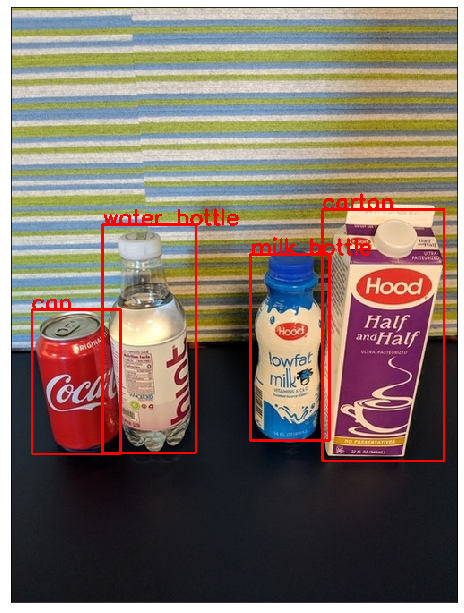

In [39]:
pred_labels, pred_boxes = get_bounding_box_from_preds(pred)
display_annotations(im_path, pred_boxes, pred_labels, categories)